In [1]:
import my_functions as my
%pylab inline

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=3)
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
yearsFmt = mdates.DateFormatter("%d/%m")

import glidertools as gt
import xarray as xr
import numpy as np
import pandas as pd

import cmocean.cm as cmo

import my_plot_params

Populating the interactive namespace from numpy and matplotlib


#### Load the glider data

In [3]:
dat_saz = xr.open_dataset('../data/dat_saz_6H.nc')
dat_pfz = xr.open_dataset('../data/dat_pfz_6H.nc')
dat_miz = xr.open_dataset('../data/dat_miz_6H.nc')

In [4]:
interp_res = '6H'
offset     = '3H'
dt=21600

# dat_saz = xr.open_dataset('../data/sg542_saz_L2.nc')
# dat_pfz = xr.open_dataset('../data/slocum_pfz_L2.nc')
# dat_miz = xr.open_dataset('../data/sg643_miz_L2.nc')

# dat_saz = dat_saz.resample(time=interp_res, loffset=offset).mean()
# dat_pfz = dat_pfz.resample(time=interp_res, loffset=offset).mean()
# dat_miz = dat_miz.resample(time=interp_res, loffset=offset).mean()

# dat_saz=dat_saz.interpolate_na(dim='time')
# dat_pfz=dat_pfz.interpolate_na(dim='time')
# dat_miz=dat_miz.interpolate_na(dim='time')

#### Load ERA5

In [ ]:
# import my_functions as my

# era5 = xr.open_mfdataset('../data/ERA5_flux_data/*.nc')
# era5 = era5.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

# # convert from J m-2 to W m-2
# var_name=['slhf', 'sshf', 'str', 'ssr', 'tp', 'e']
# era5=my.convert_era5_to_Wm2(ds=era5, var_name=var_name)

# # calculate net fluxes and emp
# era5['emp']  = (('time', 'latitude', 'longitude'), era5['e']-era5['tp'])
# era5['qnet'] = (('time', 'latitude', 'longitude'), era5['slhf']+era5['sshf']+era5['str']+era5['ssr'])

# # interp to the resolution of the glider
# era5_interp = era5.resample(time=interp_res, loffset=offset).mean()

#### Load JRA55

In [5]:
ep_jra55 = xr.open_mfdataset('../data/precipitation_evaporation/JRA55/*.nc')
hf_jra55 = xr.open_mfdataset('../data/heat_flux/JRA55/*.nc')
ws_jra55 = xr.open_mfdataset('../data/wind_speed/JRA55/*.nc')

# merge the datasets
jra55 = xr.merge([ep_jra55, hf_jra55, ws_jra55])

# correct the longitudes
jra55 = my.adjust_lon_xr_dataset(jra55, lon_name='g4_lon_2')

# Change to consisent naming convention for longitude and latitudes
jra55 = jra55.rename({'g4_lat_1'           : 'latitude',
                      'g4_lon_2'           : 'longitude',
                      'initial_time0_hours': 'time'})

# rename variables
jra55 = jra55.rename({
                      'LHTFL_GDS4_SFC_ave3h': 'slhf',
                      'SHTFL_GDS4_SFC_ave3h': 'sshf',
                      'DSWRF_GDS4_SFC_ave3h': 'dssr',
                      'USWRF_GDS4_SFC_ave3h': 'ussr',
                      'DLWRF_GDS4_SFC_ave3h': 'dstr',
                      'ULWRF_GDS4_SFC_ave3h': 'ustr',
                      'EVP_GDS4_SFC_ave3h'  : 'e',
                      'TPRAT_GDS4_SFC_ave3h': 'tp',
                      'UGRD_GDS4_HTGL'      : 'u10',
                      'VGRD_GDS4_HTGL'      : 'v10',})

jra55 = jra55.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

jra55['e']  = (('time', 'latitude', 'longitude'), -jra55['e']/(86400*1000))
jra55['tp'] = (('time', 'latitude', 'longitude'),  jra55['tp']/(86400*1000))

jra55['ssr'] = (('time', 'latitude', 'longitude'),  jra55['dssr']-jra55['ussr'])
jra55['str'] = (('time', 'latitude', 'longitude'),  jra55['dstr']-jra55['ustr'])

jra55['sshf'] = (('time', 'latitude', 'longitude'),  -jra55['sshf'])
jra55['slhf'] = (('time', 'latitude', 'longitude'),  -jra55['slhf'])

# calculate net fluxes and emp
jra55['emp']  = (('time', 'latitude', 'longitude'), jra55['e']   -jra55['tp'])
jra55['qnet'] = (('time', 'latitude', 'longitude'), jra55['slhf']+jra55['sshf']+jra55['str']+jra55['ssr'])

# interp to the resolution of the glider
jra55_interp = jra55.resample(time=interp_res, loffset=offset).mean()

#### Load MERRA2

In [7]:
ep_merra = xr.open_mfdataset('../data/precipitation_evaporation/MERRA2/*.nc4')
hf_merra = xr.open_mfdataset('../data/heat_flux/MERRA2/*.nc4')
ws_merra = xr.open_mfdataset('../data/wind_speed/MERRA2/*.nc4')

# merge the datasets
merra = xr.merge([ep_merra, hf_merra, ws_merra])
merra = merra.sel(lat=slice(-65, -40), lon=slice(-30, 30))

# correct the longitudes
merra = my.adjust_lon_xr_dataset(merra, lon_name='lon')

# Change to consisent naming convention for longitude and latitudes
merra = merra.rename({'lat': 'latitude',
                    'lon': 'longitude'})

# rename variables
merra = merra.rename({
                    'EFLUX'  : 'slhf',
                    'HFLUX'  : 'sshf',
                    'SWGNT'  : 'ssr',
                    'LWGNT'  : 'str',
                    'EVAP'   : 'e',
                    'PRECTOT': 'tp',
                    'U10M'   : 'u10',
                    'V10M'   : 'v10'})

merra['e']  = (('time', 'latitude', 'longitude'), -merra['e']/(1025))
merra['tp']  = (('time', 'latitude', 'longitude'), merra['tp']/(1025))

merra['sshf'] = (('time', 'latitude', 'longitude'),  -merra['sshf'])
merra['slhf'] = (('time', 'latitude', 'longitude'),  -merra['slhf'])

# calculate net fluxes and emp
merra['emp']  = (('time', 'latitude', 'longitude'), merra['e']   -merra['tp'])
merra['qnet'] = (('time', 'latitude', 'longitude'), merra['slhf']+merra['sshf']+merra['str']+merra['ssr'])

# interp to the resolution of the glider
merra_interp = merra.resample(time=interp_res, loffset=offset).mean()

In [8]:
# interpolate to the nearest location of the glider
from tqdm import tqdm

var_name = ['slhf','sshf','str' ,'ssr' ,'tp' ,'e' ,'emp' , 'u10', 'v10', 'qnet']

for var in tqdm(var_name):
    
#     dat_saz[var+'_era5'] = (('time'), my.interp_glider_era5(dat_saz, era5_interp, var=var))
#     dat_pfz[var+'_era5'] = (('time'), my.interp_glider_era5(dat_pfz, era5_interp, var=var))
#     dat_miz[var+'_era5'] = (('time'), my.interp_glider_era5(dat_miz, era5_interp, var=var))
    
    dat_saz[var+'_merra'] = (('time'), my.interp_glider_era5(dat_saz, merra_interp, var=var))
    dat_pfz[var+'_merra'] = (('time'), my.interp_glider_era5(dat_pfz, merra_interp, var=var))
    dat_miz[var+'_merra'] = (('time'), my.interp_glider_era5(dat_miz, merra_interp, var=var))
    
    dat_saz[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_saz, jra55_interp, var=var))
    dat_pfz[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_pfz, jra55_interp, var=var))
    dat_miz[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_miz, jra55_interp, var=var))

100%|██████████████████████████████████████████| 10/10 [25:26<00:00, 152.69s/it]


In [ ]:
# import airsea

In [ ]:
import windstress

for r, dat in enumerate([dat_saz, dat_pfz, dat_miz]):
    
    dat['tau_merra'] = (('time'), windstress.stress(np.sqrt(dat['u10_merra']**2 + dat['v10_merra']**2), z=10., drag='largepond'))
    dat['tau_jra55'] = (('time'), windstress.stress(np.sqrt(dat['u10_jra55']**2 + dat['v10_jra55']**2), z=10., drag='largepond'))
#     dat['tau_era5']  = windstress.stress(np.sqrt(dat['u10_era5'] **2 + dat['v10_era5'] **2), z=10., drag='largepond')

### Figure compare

In [32]:
dat_saz_1D = dat_saz.resample(time='1D', loffset='12H').mean(dim='time')
dat_pfz_1D = dat_pfz.resample(time='1D', loffset='12H').mean(dim='time')
dat_miz_1D = dat_miz.resample(time='1D', loffset='12H').mean(dim='time')

In [35]:
print('jra-era:   ' + str(np.sqrt((dat_saz_1D['qnet_jra55']-dat_saz_1D['qnet']) **2).mean().values))
print('jra-merra: ' + str(np.sqrt((dat_saz_1D['qnet_jra55']-dat_saz_1D['qnet_merra'])**2).mean().values))
print('era-merra: ' + str(np.sqrt((dat_saz_1D['qnet']      -dat_saz_1D['qnet_merra'])**2).mean().values))

jra-era:   32.85865076613236
jra-merra: 43.75588768698302
era-merra: 45.190537375248695


Text(0, 0.5, 'E-P (m s$^{-1}$)')

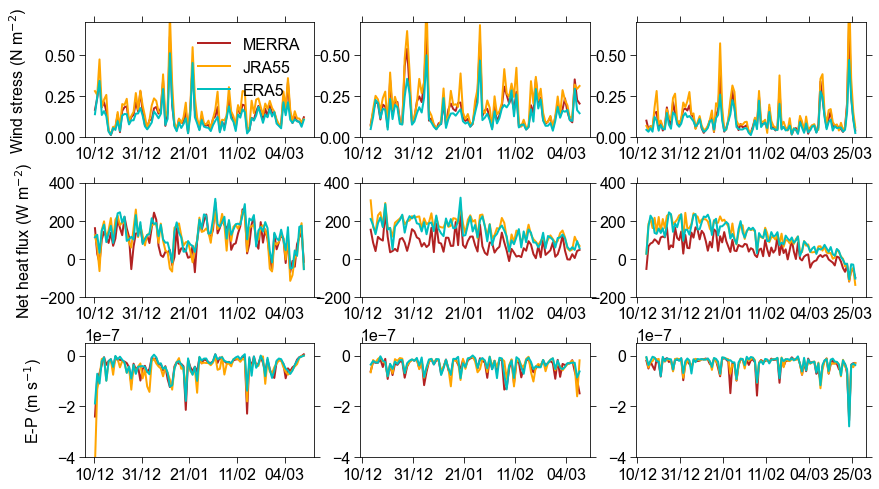

In [36]:
fig,ax=subplots(3,3, figsize=[14, 8]) 
fig.subplots_adjust(hspace=0.4)

for r, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):
    
    for c, var in enumerate(['tau', 'qnet', 'emp']):
        
        ax[c, r].plot(dat.time.values, dat[var+'_merra'], label='MERRA', c='firebrick')
        ax[c, r].plot(dat.time.values, dat[var+'_jra55'], label='JRA55', c='orange')
        ax[c, r].plot(dat.time.values, dat[var] , label='ERA5', c='c')
        
        ax[0, c].set_ylim(0, 0.7)
        ax[1, c].set_ylim(-200, 400)
        ax[2, c].set_ylim(-4e-7, 0.5e-7)
        
        ax[r,c].xaxis.set_major_locator(weeks)
        ax[r,c].xaxis.set_major_formatter(yearsFmt)

        ax[r,c].yaxis.set_ticks_position('both')
        ax[r,c].xaxis.set_ticks_position('both')
        
ax[0,0].legend(frameon=False)

# ylabels
ax[0,0].set_ylabel('Wind stress (N m$^{-2}$)', labelpad=15)
ax[1,0].set_ylabel('Net heat flux (W m$^{-2}$)')
ax[2,0].set_ylabel('E-P (m s$^{-1}$)', labelpad=13)

# savefig('../figures/Fig_S2_reanalysis_comparisons_colocated.png', dpi=300)

#### Freshwater and heat flux terms

In [58]:
dat_saz_1D = dat_saz.resample(time='1D', loffset='12H').mean(dim='time')
dat_pfz_1D = dat_pfz.resample(time='1D', loffset='12H').mean(dim='time')
dat_miz_1D = dat_miz.resample(time='1D', loffset='12H').mean(dim='time')

In [39]:
import ml_budget as mlb 

In [75]:
for dat in [dat_saz, dat_pfz, dat_miz]:
    
    dat['ml_s_smooth'] = dat['ml_s_smooth'].bfill(dim='time').ffill(dim='time')
    dat['ml_t_smooth'] = dat['ml_t_smooth'].bfill(dim='time').ffill(dim='time')

    mld = dat['mld_03']  
    S   = dat['ml_s_smooth']
    
    # merrra
    Q_merra = dat['qnet_merra']
    E_merra = dat['e_merra']   
    P_merra = dat['tp_merra'] 
    
    # jra55
    Q_jra55 = dat['qnet_jra55']
    E_jra55 = dat['e_jra55']   
    P_jra55 = dat['tp_jra55'] 
    
    # era5
    Q_era5  = dat['qnet']
    E_era5  = dat['e']   
    P_era5  = dat['tp'] 
    
    # surface fluxes era5
    dat['dT_hf_era5']    = mlb.heatflux(Q=Q_era5, mld=mld)      
    dat['dS_ff_era5']    = mlb.freshwaterflux(E=E_era5, P=P_era5, mld=mld, S=S)
    
    # surface fluxes jra55
    dat['dT_hf_jra55']    = mlb.heatflux(Q=Q_jra55, mld=mld)      
    dat['dS_ff_jra55']    = mlb.freshwaterflux(E=E_jra55, P=P_jra55, mld=mld, S=S)
    
    # surface fluxes jra55
    dat['dT_hf_merra']    = mlb.heatflux(Q=Q_merra, mld=mld)      
    dat['dS_ff_merra']    = mlb.freshwaterflux(E=E_merra, P=P_merra, mld=mld, S=S)
    
    dat = mlb.entrainment(dat=dat, mld=dat['mld_03'], xld=dat['xld_est'], dt=21600)
            
# ekman transport
dat_saz = mlb.ekman_transport(dat_saz, dt=86400, grad='tsg')
dat_pfz = mlb.ekman_transport(dat_pfz, dt=86400, grad='tsg')
dat_miz = mlb.ekman_transport(dat_miz, dt=86400, grad='grad')

In [102]:
reanalyses = ['era5', 'jra55', 'merra']
for dat in [dat_saz, dat_pfz, dat_miz]:
        
    for i, val in enumerate(reanalyses):
    
        dat['hf_dT'+'_'+str(val)] = dat['dT_hf'+'_'+str(val)]*86400
        dat['ek_dT'] = dat['ek_trans_dT']*86400
        dat['en_dT'] = dat['ent_dT']     *86400
        
        dat['ff_dS'+'_'+str(val)] = dat['dS_ff'+'_'+str(val)]*86400
        dat['ek_dS'] = dat['ek_trans_dS']*86400
        dat['en_dS'] = dat['ent_dS']     *86400
        
        dat['net_terms_dT'+'_'+str(val)] = dat['hf_dT'+'_'+str(val)] + dat['ek_dT'] + dat['en_dT'] 
        dat['net_terms_dS'+'_'+str(val)] = dat['ff_dS'+'_'+str(val)] + dat['ek_dS'] + dat['en_dS'] 

In [103]:
dat_saz_1D = dat_saz.resample(time='1D', loffset='12H').mean(dim='time')
dat_pfz_1D = dat_pfz.resample(time='1D', loffset='12H').mean(dim='time')
dat_miz_1D = dat_miz.resample(time='1D', loffset='12H').mean(dim='time')

In [104]:
for dat in [dat_saz_1D, dat_pfz_1D, dat_miz_1D]:
    
    dat['glider_dT'] = dat['ml_t_smooth'].diff(dim='time')
    dat['glider_dS'] = dat['ml_s_smooth'].diff(dim='time')

In [98]:
np.sqrt((dat['net_terms_dT_'+str(val)]-dat.glider_dT)**2).mean()

<xarray.DataArray ()>
array(0.06494779)

In [113]:
names = ['SAZ', 'PFZ', 'MIZ']

for ii, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):
    
    print(names[ii])
    
    for i, val in enumerate(reanalyses):
    
        rmse=np.sqrt((dat['net_terms_dT_'+str(val)]-dat.glider_dT)**2).mean()
            
        print(str(val)+': '+str(rmse.values)+' degC per day')

SAZ
era5: 0.06494779090005706 degC per day
jra55: 0.06427848420347981 degC per day
merra: 0.05877561228840847 degC per day
PFZ
era5: 0.02421093525951463 degC per day
jra55: 0.023830903532847635 degC per day
merra: 0.025580746466862574 degC per day
MIZ
era5: 0.06339603896002781 degC per day
jra55: 0.06473639148407824 degC per day
merra: 0.06092569645654362 degC per day


In [116]:
0.065-0.059

0.006000000000000005

In [114]:
for ii, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):
    
    print(names[ii])
    
    for i, val in enumerate(reanalyses):
    
        rmse=np.sqrt((dat['net_terms_dS_'+str(val)]-dat.glider_dS)**2).mean()
            
        print(str(val)+': '+str(rmse.values)+' g kg-1 per day')

SAZ
era5: 0.007454400660082835 g kg-1 per day
jra55: 0.007826408621613353 g kg-1 per day
merra: 0.007534123759339532 g kg-1 per day
PFZ
era5: 0.0037302904063603952 g kg-1 per day
jra55: 0.003716493952651491 g kg-1 per day
merra: 0.003751287511224598 g kg-1 per day
MIZ
era5: 0.011660049729995934 g kg-1 per day
jra55: 0.011599800845109528 g kg-1 per day
merra: 0.011522962204767895 g kg-1 per day


In [128]:
dat_saz_1D['glider_dT'].std()

<xarray.DataArray 'glider_dT' ()>
array(0.07638446)

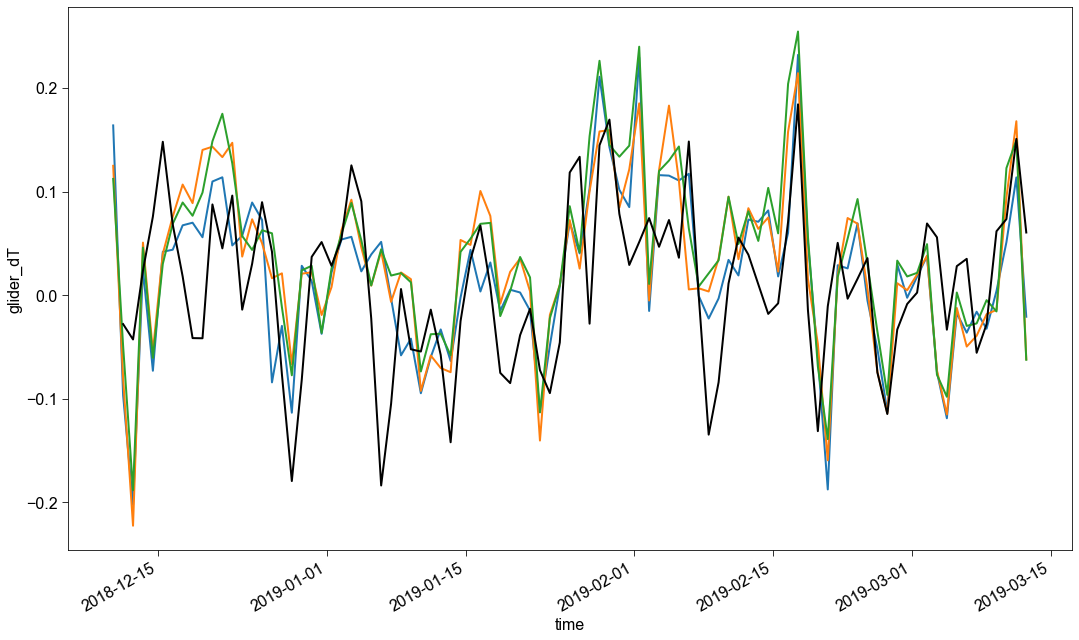

In [86]:
dat_saz_1D.net_terms_dT_merra.plot()
dat_saz_1D.net_terms_dT_jra55.plot()
dat_saz_1D.net_terms_dT_era5.plot()
dat_saz_1D.glider_dT.plot(c='k')